# Plot exoplanet occurrence rate as a function of age.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import requests
import os
import io
import pandas as pd

# from detection_efficiency_functions import *
# from data_wrangling import *
# from plotting import *

from scipy.stats import gamma

from tqdm import tqdm

In [2]:
def get_catalog(name, basepath="data"):
    fn = os.path.join(basepath, "{0}.h5".format(name))
    if os.path.exists(fn):
        return pd.read_hdf(fn, name)
    if not os.path.exists(basepath):
        os.makedirs(basepath)
    print("Downloading {0}...".format(name))
    url = ("http://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/"
           "nph-nstedAPI?table={0}&select=*").format(name)
    r = requests.get(url)
    if r.status_code != requests.codes.ok:
        r.raise_for_status()
    fh = io.BytesIO(r.content)
    df = pd.read_csv(fh)
    df.to_hdf(fn, name, format="t")
    return df

In [3]:
stlr_n = get_catalog("q1_q16_stellar")

In [4]:
stlr_n.keys();

Load Travis Berger's catalog

In [5]:
berger = pd.read_csv("../../data/Berger_2020.tsv", delimiter=";", skiprows=90)
berger.keys();

Load Lucy's catalog

In [6]:
# Put in whatever you want here.
# lu = pd.read_csv("../../data/lu_kinematic_ages.csv", delimiter=",", skiprows=72)
# lu.keys();

Merge travis and lucy's catalogs

In [7]:
adf = berger * 1
adf["age"] = berger.Age.values

In [8]:
stripped_adf = pd.DataFrame(dict({"kepid": adf.KIC.values, "age": adf.age.values}))  
stlr = pd.merge(stlr_n, stripped_adf, on="kepid", how="left")
print(np.shape(stripped_adf), np.shape(stlr_n), np.shape(stlr))

(186301, 2) (198917, 99) (198917, 100)


In [9]:
cdpp_cols = [k for k in stlr.keys() if k.startswith("rrmscdpp")]
cdpp_vals = np.array([k[-4:].replace("p", ".") for k in cdpp_cols], dtype=float)

# Pre-compute and freeze the gamma function from Equation (5) in
# Burke et al.
pgam = gamma(4.65, loc=0., scale=0.98)
mesthres_cols = [k for k in stlr.keys() if k.startswith("mesthres")]
mesthres_vals = np.array([k[-4:].replace("p", ".") for k in mesthres_cols],
                         dtype=float)

# Lines to change for different stellar parameters.
var_names = ["koi_period", "koi_prad", "teff"]

# period_rng = (5, 500)
# rp_rng = (0.55, 2.5)
teff_rng = (3000, 7000)
age_rng = (.001, 9)
period_rng = (50, 300)
rp_rng = (0.75, 2.5)
# rp_rng = (0.75, 2.5)

Plot an age histogram

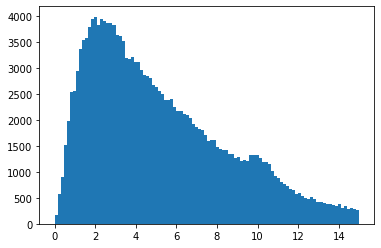

In [10]:
plt.hist(stlr.age.values[np.isfinite(stlr.age.values)], 100, range=(0, 15));

Apply cuts to the data

In [11]:
# Select G and K dwarfs.
m = (teff_rng[0] <= stlr.teff) & (stlr.teff <= teff_rng[1])
m &= (age_rng[0] <= stlr.age) & (stlr.age <= age_rng[1])
m &= np.isfinite(stlr.age)
m &= stlr.radius <= 1.15

# Only include stars with sufficient data coverage.
m &= stlr.dataspan > 365.25*2.
m &= stlr.dutycycle > 0.6
m &= stlr.rrmscdpp07p5 <= 1000.

# Only select stars with mass estimates.
m &= np.isfinite(stlr.mass)

base_stlr = pd.DataFrame(stlr)
stlr = pd.DataFrame(stlr[m])

print("Selected {0} targets after cuts".format(len(stlr)))

Selected 85828 targets after cuts


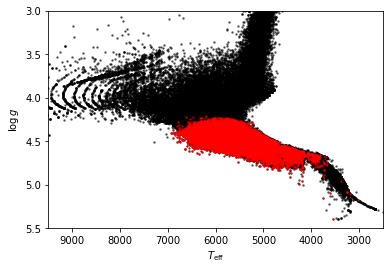

In [12]:
plt.plot(stlr_n.teff, stlr_n.logg, ".k", ms=3, alpha=0.5)
plt.plot(stlr.teff, stlr.logg, ".r", ms=3, alpha=0.5)
plt.xlim(9500, 2500)
plt.ylim(5.5, 3)
plt.ylabel("$\log g$");
plt.xlabel("$T_\mathrm{eff}$");

In [13]:
kois = get_catalog("q1_q16_koi")
len(kois)

# Join on the stellar list.
kois = pd.merge(kois, stlr, on="kepid", how="inner", suffixes=["_koi", "_kin"])
print(np.shape(kois))

# Only select the KOIs in the relevant part of parameter space.
# m = kois.koi_pdisposition == "CONFIRMED"
# print(sum(m))
# m &= np.isfinite(kois.age_kin.values)
# print(sum(m))
# base_kois = pd.DataFrame(kois[m])
# print(sum(m))
m = (period_rng[0] <= kois.koi_period) & (kois.koi_period <= period_rng[1])
print(sum(m))
m &= np.isfinite(kois.koi_prad) & (rp_rng[0] <= kois.koi_prad)
print(sum(m))
m &= (kois.koi_prad <= rp_rng[1])
print(sum(m))

kois = pd.DataFrame(kois[m])

print("Selected {0} KOIs after cuts".format(len(kois)))

(3742, 252)
570
515
243
Selected 243 KOIs after cuts


In [14]:
kois.keys()

Index(['kepid', 'kepoi_name', 'kepler_name', 'ra_koi', 'ra_err', 'ra_str',
       'dec_koi', 'dec_err', 'dec_str', 'koi_gmag',
       ...
       'timeout07p5', 'timeout09p0', 'timeout10p5', 'timeout12p0',
       'timeout12p5', 'timeout15p0', 'timeoutsumry', 'cdppslplong',
       'cdppslpshrt', 'age'],
      dtype='object', length=252)

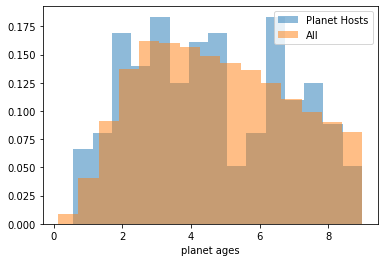

In [15]:
plt.hist(kois.age.values, 15, density=True, alpha=.5, label="Planet Hosts");
plt.hist(stlr.age.values, 15, density=True, alpha=.5, label="All");
plt.xlabel("planet ages")
plt.legend()

In [16]:
# def get_completeness(star, period, rp, e, cdpp_cols, cdpp_vals, pgam, mesthres_cols, 
#                      mesthres_vals, with_geom=True):
#     """
#     A helper function to combine all the completeness effects.
    
#     :param star:      a pandas row giving the stellar properties
#     :param period:    the period in days
#     :param c_grid:    the stellar property grid
#     :param c:         the stellar property of this star.
#     :param rp:        the planet radius in Earth radii
#     :param e:         the orbital eccentricity
#     :param with_geom: include the geometric transit probability?
    
#     """
#     aor = get_a(period, star.mass) / star.radius
# #     pdet = get_pdet(star, aor, period, rp, e, cdpp_cols, cdpp_vals, pgam, mesthres_cols, 
# #                     mesthres_vals)
#     pdet = get_pdet(star, aor, period, rp, e)
#     pwin = get_pwin(star, period)
#     if not with_geom:
#         return pdet * pwin
#     pgeom = get_pgeom(aor, e)
#     return pdet * pwin * pgeom

In [17]:
def get_duration(period, aor, e):
    """
    Equation (1) from Burke et al. This estimates the transit
    duration in the same units as the input period. There is a
    typo in the paper (24/4 = 6 != 4).
    
    :param period: the period in any units of your choosing
    :param aor:    the dimensionless semi-major axis (scaled
                   by the stellar radius)
    :param e:      the eccentricity of the orbit
    
    """
    return 0.25 * period * np.sqrt(1 - e**2) / aor

def get_a(period, mstar, Go4pi=2945.4625385377644/(4*np.pi*np.pi)):
    """
    Compute the semi-major axis of an orbit in Solar radii.
    
    :param period: the period in days
    :param mstar:  the stellar mass in Solar masses
    
    """
    return (Go4pi*period*period*mstar) ** (1./3)

def get_delta(k, c=1.0874, s=1.0187):
    """
    Estimate the approximate expected transit depth as a function
    of radius ratio. There might be a typo here. In the paper it
    uses c + s*k but in the public code, it is c - s*k:
    https://github.com/christopherburke/KeplerPORTs
    
    :param k: the dimensionless radius ratio between the planet and
              the star
    
    """
    delta_max = k*k * (c + s*k)
    return 0.84 * delta_max

cdpp_cols = [k for k in stlr.keys() if k.startswith("rrmscdpp")]
cdpp_vals = np.array([k[-4:].replace("p", ".") for k in cdpp_cols], dtype=float)
def get_mes(star, period, rp, tau, re=0.009171):
    """
    Estimate the multiple event statistic value for a transit.
    
    :param star:   a pandas row giving the stellar properties
    :param period: the period in days
    :param rp:     the planet radius in Earth radii
    :param tau:    the transit duration in hours
    
    """
    # Interpolate to the correct CDPP for the duration.
    cdpp = np.array(star[cdpp_cols], dtype=float)
    sigma = np.interp(tau, cdpp_vals, cdpp)

    # Compute the radius ratio and estimate the S/N.
    k = rp * re / star.radius
    snr = get_delta(k) * 1e6 / sigma
    
    # Scale by the estimated number of transits.
    ntrn = star.dataspan * star.dutycycle / period 
    return snr * np.sqrt(ntrn)

# Pre-compute and freeze the gamma function from Equation (5) in
# Burke et al.
pgam = gamma(4.65, loc=0., scale=0.98)
mesthres_cols = [k for k in stlr.keys() if k.startswith("mesthres")]
mesthres_vals = np.array([k[-4:].replace("p", ".") for k in mesthres_cols],
                         dtype=float)
def get_pdet(star, aor, period, rp, e):
    """
    Equation (5) from Burke et al. Estimate the detection efficiency
    for a transit.
    
    :param star:   a pandas row giving the stellar properties
    :param aor:    the dimensionless semi-major axis (scaled
                   by the stellar radius)
    :param period: the period in days
    :param rp:     the planet radius in Earth radii
    :param e:      the orbital eccentricity
    
    """
    tau = get_duration(period, aor, e) * 24.
    mes = get_mes(star, period, rp, tau)
    mest = np.interp(tau, mesthres_vals,
                     np.array(star[mesthres_cols],
                              dtype=float))
    x = mes - 4.1 - (mest - 7.1)
    return pgam.cdf(x)

def get_pwin(star, period):
    """
    Equation (6) from Burke et al. Estimates the window function
    using a binomial distribution.
    
    :param star:   a pandas row giving the stellar properties
    :param period: the period in days
    
    """
    M = star.dataspan / period
    f = star.dutycycle
    omf = 1.0 - f
    pw = 1 - omf**M - M*f*omf**(M-1) - 0.5*M*(M-1)*f*f*omf**(M-2)
    msk = (pw >= 0.0) * (M >= 2.0)
    return pw * msk

def get_pgeom(aor, e):
    """
    The geometric transit probability.
    
    See e.g. Kipping (2014) for the eccentricity factor
    http://arxiv.org/abs/1408.1393
    
    :param aor: the dimensionless semi-major axis (scaled
                by the stellar radius)
    :param e:   the orbital eccentricity

    """
    return 1. / (aor * (1 - e*e)) * (aor > 1.0)

def get_completeness(star, period, rp, e, with_geom=True):
    """
    A helper function to combine all the completeness effects.
    
    :param star:      a pandas row giving the stellar properties
    :param period:    the period in days
    :param rp:        the planet radius in Earth radii
    :param e:         the orbital eccentricity
    :param with_geom: include the geometric transit probability?
    
    """
    aor = get_a(period, star.mass) / star.radius
    pdet = get_pdet(star, aor, period, rp, e)
    pwin = get_pwin(star, period)
    if not with_geom:
        return pdet * pwin
    pgeom = get_pgeom(aor, e)
    return pdet * pwin * pgeom

Plot the detection efficiency for a single star

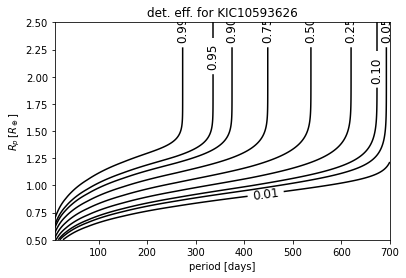

In [18]:
# Choose the star.
star = stlr[stlr.kepid == 10593626].iloc[0]

# Compute the completeness map on a grid.
period = np.linspace(10, 700, 500)
rp = np.linspace(0.5, 2.5, 421)
X, Y = np.meshgrid(period, rp, indexing="ij")
Z = get_completeness(star, X, Y, 0.0, with_geom=False)

# Plot with the same contour levels as the figure.
c = plt.contour(X, Y, Z, [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99], colors="k")
plt.clabel(c, fontsize=12, inline=1, fmt="%.2f") 
plt.xlabel("period [days]")
plt.ylabel("$R_p \, [R_\oplus]$")
plt.title("det. eff. for KIC10593626");

Plot the detection efficiency over the range of parameter space

In [19]:
period = np.linspace(period_rng[0], period_rng[1], 57)
rp = np.linspace(rp_rng[0], rp_rng[1], 61)
period_grid, rp_grid = np.meshgrid(period, rp, indexing="ij")
comp = np.zeros_like(period_grid)
for _, star in stlr.iterrows():
    comp += get_completeness(star, period_grid, rp_grid, 0.0, with_geom=True)
    
# plt.pcolor(period_grid, rp_grid, comp, cmap="BuGn")
# c = plt.contour(period_grid, rp_grid, comp / len(stlr),
#                colors="k", alpha=0.8)
# plt.clabel(c, fontsize=12, inline=1, fmt="%.3f")
# plt.title("mean pipeline detection efficiency")
# plt.xlabel("period [days]")
# plt.ylabel("$R_p \, [R_\oplus]$");

In [20]:
# A double power law model for the population.
def population_model(theta, period, rp):
    lnf0, beta, alpha = theta
    v = np.exp(lnf0) * np.ones_like(period)
    for x, rng, n in zip((period, rp),
                         (period_rng, rp_rng),
                         (beta, alpha)):
        n1 = n + 1
        v *= x**n*n1 / (rng[1]**n1-rng[0]**n1)
    return v

# The ln-likelihood function given at the top of this post.
koi_periods = np.array(kois.koi_period)
koi_rps = np.array(kois.koi_prad)
vol = np.diff(period_grid, axis=0)[:, :-1] * np.diff(rp_grid, axis=1)[:-1, :]
def lnlike(theta):
    pop = population_model(theta, period_grid, rp_grid) * comp
    pop = 0.5 * (pop[:-1, :-1] + pop[1:, 1:])
    norm = np.sum(pop * vol)
    ll = np.sum(np.log(population_model(theta, koi_periods, koi_rps))) - norm
    return ll if np.isfinite(ll) else -np.inf

# The ln-probability function is just propotional to the ln-likelihood
# since we're assuming uniform priors.
bounds = [(-5, 5), (-5, 5), (-5, 5)]
def lnprob(theta):
    # Broad uniform priors.
    for t, rng in zip(theta, bounds):
        if not rng[0] < t < rng[1]:
            return -np.inf
    return lnlike(theta)

# The negative ln-likelihood is useful for optimization.
# Optimizers want to *minimize* your function.
def nll(theta):
    ll = lnlike(theta)
    return -ll if np.isfinite(ll) else 1e15

In [21]:
from scipy.optimize import minimize
theta_0 = np.array([np.log(0.75), -0.53218, -1.5])
r = minimize(nll, theta_0, method="L-BFGS-B", bounds=bounds)
print(r)

      fun: 1688.9615378740712
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.27373674e-05,  2.27373676e-05, -4.54747354e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 48
      nit: 9
     njev: 12
   status: 0
  success: True
        x: array([ 0.66291602, -0.17536418, -2.15414124])


[2.68762902]


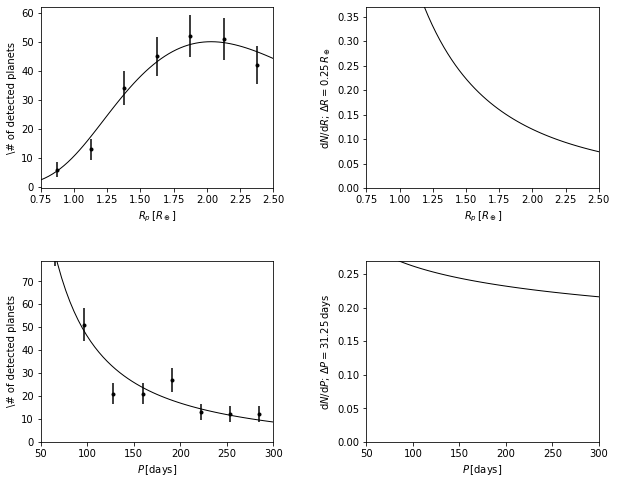

In [22]:
# We'll reuse these functions to plot all of our results.
def make_plot(pop_comp, x0, x, y, ax):
    pop = 0.5 * (pop_comp[:, 1:] + pop_comp[:, :-1])
    pop = np.sum(pop * np.diff(y)[None, :, None], axis=1)
    a, b, c, d, e = np.percentile(pop * np.diff(x)[0], [2.5, 16, 50, 84, 97.5], axis=0)

    ax.fill_between(x0, a, e, color="k", alpha=0.1, edgecolor="none")
    ax.fill_between(x0, b, d, color="k", alpha=0.3, edgecolor="none")
    ax.plot(x0, c, "k", lw=1)

def plot_results(samples):
    # Loop through the samples and compute the list of population models.
    samples = np.atleast_2d(samples)
    pop = np.empty((len(samples), period_grid.shape[0], period_grid.shape[1]))
    gamma_earth = np.empty((len(samples)))
    for i, p in enumerate(samples):
        pop[i] = population_model(p, period_grid, rp_grid)
        gamma_earth[i] = population_model(p, 365.25, 1.0) * 365.
        
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    fig.subplots_adjust(wspace=0.4, hspace=0.4)
    
    # Integrate over period.
    dx = 0.25
    x = np.arange(rp_rng[0], rp_rng[1] + dx, dx)
    n, _ = np.histogram(koi_rps, x)
    
    # Plot the observed radius distribution.
    ax = axes[0, 0]
    make_plot(pop * comp[None, :, :], rp, x, period, ax)
    ax.errorbar(0.5*(x[:-1]+x[1:]), n, yerr=np.sqrt(n), fmt=".k",
                capsize=0)
    ax.set_xlim(rp_rng[0], rp_rng[1])
    ax.set_xlabel("$R_p\,[R_\oplus]$")
    ax.set_ylabel("\# of detected planets")
    
    # Plot the true radius distribution.
    ax = axes[0, 1]
    make_plot(pop, rp, x, period, ax)
    ax.set_xlim(rp_rng[0], rp_rng[1])
    ax.set_ylim(0, 0.37)
    ax.set_xlabel("$R_p\,[R_\oplus]$")
    ax.set_ylabel("$\mathrm{d}N / \mathrm{d}R$; $\Delta R = 0.25\,R_\oplus$")
    
    # Integrate over period.
    dx = 31.25
    x = np.arange(period_rng[0], period_rng[1] + dx, dx)
    n, _ = np.histogram(koi_periods, x)
    
    # Plot the observed period distribution.
    ax = axes[1, 0]
    make_plot(np.swapaxes(pop * comp[None, :, :], 1, 2), period, x, rp, ax)
    ax.errorbar(0.5*(x[:-1]+x[1:]), n, yerr=np.sqrt(n), fmt=".k",
                capsize=0)
    ax.set_xlim(period_rng[0], period_rng[1])
    ax.set_ylim(0, 79)
    ax.set_xlabel("$P\,[\mathrm{days}]$")
    ax.set_ylabel("\# of detected planets")
    
    # Plot the true period distribution.
    ax = axes[1, 1]
    make_plot(np.swapaxes(pop, 1, 2), period, x, rp, ax)
    ax.set_xlim(period_rng[0], period_rng[1])
    ax.set_ylim(0, 0.27)
    ax.set_xlabel("$P\,[\mathrm{days}]$")
    ax.set_ylabel("$\mathrm{d}N / \mathrm{d}P$; $\Delta P = 31.25\,\mathrm{days}$")
    
    return gamma_earth

print(plot_results(r.x));

In [23]:
N = int(1e5)

In [24]:
np.random.seed(123)
period_samp = np.random.uniform(period_rng[0], period_rng[1], N)
radius_samp = np.random.uniform(rp_rng[0], rp_rng[1], N)

star_ind = np.random.randint(len(stlr), size=N)
age_samp = stlr.age.values[star_ind]

# Assume eccentricity = 0
e = 0

Q_samp = np.empty(N)
for i, (_, star) in tqdm(enumerate(stlr.iterrows()), total=len(stlr)):
    m = star_ind == i
    if not np.any(m):
        continue
#     Q_samp[m] = get_completeness(star, period_samp[m], radius_samp[m], e, 
#                                  cdpp_cols, cdpp_vals, pgam, mesthres_cols,
#                                  mesthres_vals)
    Q_samp[m] = get_completeness(star, period_samp[m], radius_samp[m], e)

100%|██████████| 85828/85828 [01:32<00:00, 924.07it/s] 


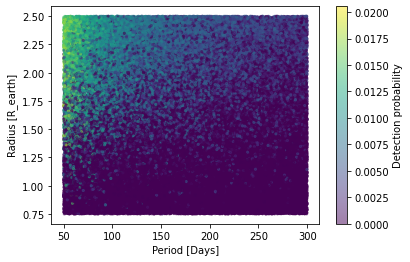

In [25]:
plt.scatter(period_samp, radius_samp, c=Q_samp, s=5, alpha=.5)
plt.xlabel("Period [Days]")
plt.ylabel("Radius [R_earth]")
plt.colorbar(label="Detection probability") # Probability of detecting planet at that period and radiu

In [26]:
# X_samp = np.vstack((period_samp, radius_samp, jz_samp/100)).T  # Now 1 Jz 'unit' is 100 K
X_samp = np.vstack((period_samp, radius_samp, age_samp)).T
bins = [np.linspace(period_rng[0], period_rng[1], 3), 
        np.linspace(rp_rng[0], rp_rng[1], 3),
        np.linspace(age_rng[0], age_rng[1], 3)]

numerator, _ = np.histogramdd(X_samp, bins, weights=Q_samp)
denominator, _ = np.histogramdd(X_samp, bins)

# Multiply the denom by the observed distribution of Jzs which includes the selection function
# Need to do this for each stellar property.
denominator *= np.histogram(age_samp, bins[2], normed=True)[0][None, None, :]

# broadcast the bin widths over the 8*10*2 grid then take the product to get the volume.
volume = np.prod(np.meshgrid(*map(np.diff, bins), indexing="ij"), axis=0)

numerator *= volume

integrated_det_eff = numerator/denominator

/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  if sys.path[0] == '':


In [27]:
X = np.vstack((kois.koi_period.values, kois.koi_prad.values, kois.age.values)).T

In [28]:
hist_of_observed_planets = np.histogramdd(X, bins)[0]
theta = hist_of_observed_planets/integrated_det_eff
theta_var = theta/integrated_det_eff
theta.shape

(2, 2, 2)

Text(0.5, 0, 'Age')

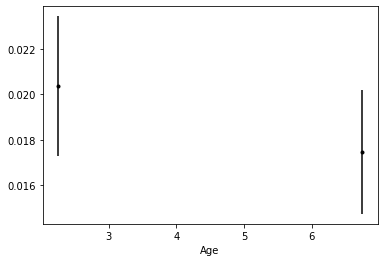

In [29]:
marg_volume = np.prod(np.meshgrid(*map(np.diff, [bins[0], bins[1]]), indexing="ij"), axis=0)
occ = np.sum(marg_volume[:, :, None]*theta, axis=(0, 1))
err = np.sqrt(np.sum(marg_volume[:, :, None]**2*theta_var, axis=(0, 1)))
plt.errorbar(.5 * (bins[2][:-1] + bins[2][1:]), occ/len(stlr), yerr=err/len(stlr), fmt="k.")
plt.xlabel("Age")